In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pdb
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

import torch
from torch import nn
from torch.cuda.amp import GradScaler, autocast
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam, lr_scheduler
import torchvision
import torchvision.transforms as T

from sys import platform

DEVICE = 'mps' if platform == 'darwin' else 'cuda'
if DEVICE == 'mps':
    DOWNLOAD_PATH = '/Users/georgestoica/Downloads' 
else:
    DOWNLOAD_PATH = '/srv/share/gstoica3/checkpoints/REPAIR/'
    
torch.autograd.set_grad_enabled(False)

/srv/share/gstoica3/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from kmeans_pytorch import kmeans, kmeans_predict

In [3]:
from copy import deepcopy
from collections import defaultdict

In [4]:
from resnets import resnet20
from matching_algs import *
from model_matchings import *
from utils import *

In [5]:
cifar100_info = {
    'dir': '/nethome/gstoica3/research/pytorch-cifar100/data/cifar-100-python',
    'classes1': np.arange(50),
    'classes2': np.arange(50, 100),
    'num_classes': 100,
    'split_classes': 50
}

cifar10_info = {
    'dir': '/tmp',
    'classes1': np.array([3, 2, 0, 6, 4]),
    'classes2': np.array([5, 7, 9, 8, 1]),
    'num_classes': 10,
    'split_classes': 5
}

ds_info = cifar10_info

In [6]:
CIFAR_MEAN = [125.307, 122.961, 113.8575]
CIFAR_STD = [51.5865, 50.847, 51.255]
normalize = T.Normalize(np.array(CIFAR_MEAN)/255, np.array(CIFAR_STD)/255)
denormalize = T.Normalize(-np.array(CIFAR_MEAN)/np.array(CIFAR_STD), 255/np.array(CIFAR_STD))

train_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomCrop(32, padding=4),
    T.ToTensor(),
    normalize,
])
test_transform = T.Compose([
    T.ToTensor(),
    normalize,
])
train_dset = torchvision.datasets.CIFAR10(root=cifar10_info['dir'], train=True,
                                        download=True, transform=train_transform)
test_dset = torchvision.datasets.CIFAR10(root=cifar10_info['dir'], train=False,
                                        download=True, transform=test_transform)

train_aug_loader = torch.utils.data.DataLoader(train_dset, batch_size=500, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=500, shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
train_aug_loader = torch.utils.data.DataLoader(train_dset, batch_size=500, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=500, shuffle=False, num_workers=8)

In [8]:
def save_model(model, i):
    sd = model.state_dict()
    path = os.path.join(
        # '/Users/georgestoica/Downloads',
        DOWNLOAD_PATH,
        '%s.pth.tar' % i
    )
    torch.save(model.state_dict(), path)

def load_model(model, i):
    path = os.path.join(
        # '/Users/georgestoica/Downloads',
        DOWNLOAD_PATH,
        '%s.pth.tar' % i
    )
    sd = torch.load(path, map_location=torch.device(DEVICE))
    model.load_state_dict(sd)
    return model


In [9]:
modela = load_model(
    resnet20(w=4, num_classes=10).to(DEVICE),
    'resnet20x4_v1'
)

modelb = load_model(
    resnet20(w=4, num_classes=10).to(DEVICE),
    'resnet20x4_v2'
)

In [10]:
DEVICE = 'cuda:0'
# evaluates accuracy
def evaluate(model, loader=test_loader, return_confusion=False):
    model.eval()
    correct = 0
    confusion_matrix = np.zeros((10, 10))
    with torch.no_grad(), autocast():
        for inputs, labels in loader:
            outputs = model(inputs.to(DEVICE))
            pred = outputs.argmax(dim=1)
            correct += (labels.to(DEVICE) == pred).sum().item()
            confusion_matrix[labels.cpu().numpy(), pred.cpu().numpy()] += 1
    confusion_matrix /= confusion_matrix.sum(-1, keepdims=True)
    if return_confusion:
        return correct, confusion_matrix
    else:
        return correct

In [37]:
def match_tensors_exact_bipartite_dist(
    hull_tensor,
    interleave=False,
    random_perm=False
):
    cdists = torch.cdist(hull_tensor, hull_tensor)
#     hull_normed = hull_tensor / hull_tensor.norm(dim=-1, keepdim=True)
    O = hull_tensor.shape[0]
    remainder = int(hull_tensor.shape[0] * (1-r))
    bound = O - remainder
#     sims = hull_normed @ hull_normed.transpose(-1, -2)
    sims = -cdists
    torch.diagonal(sims)[:] = -torch.inf
    permutation_matrix = torch.zeros((O, O - bound), device=sims.device)
    for i in range(bound):
        best_idx = sims.view(-1).argmax()
        row_idx = best_idx % sims.shape[1]
        col_idx = best_idx // sims.shape[1]
        permutation_matrix[row_idx, i] = 1
        permutation_matrix[col_idx, i] = 1
        sims[row_idx] = -torch.inf
        sims[col_idx] = -torch.inf
        sims[:, row_idx] = -torch.inf
        sims[:, col_idx] = -torch.inf
    
    unused = (sims.max(-1)[0] > -torch.inf).to(torch.int).nonzero().view(-1)
    for i in range(bound, O-bound):
        permutation_matrix[unused[i-bound], i] = 1
    merge = permutation_matrix / (permutation_matrix.sum(dim=0, keepdim=True) + 1e-5)
    unmerge = permutation_matrix
    return merge.T, unmerge


In [11]:
def find_transform_differences(old_transforms, current_transforms):
    if len(old_transforms) == 0:
        return {}
    transform2norm = {}
    for key, old_transform in old_transforms.items():
        current_transform = current_transforms[key]
        old_align = old_transform.output_align
        new_align = current_transform.output_align
        cost = old_align.T @ new_align
        row_ind, col_idx = scipy.optimize.linear_sum_assignment(cost.detach().cpu().numpy())
        permutation = torch.eye(new_align.shape[1], device=old_align.device)[col_idx]
        aligned_new = new_align @ permutation
#         pdb.set_trace()
        norm = torch.norm(old_align - aligned_new).cpu().numpy()
        transform2norm[key] = norm
    return transform2norm

In [38]:
r = 0.5
set_r(r)
set_match_fn(match_tensors_exact_bipartite_dist)

match_tensors = match_wrapper(
    match_tensors_exact_bipartite_dist, interleave=False, random_perm=False
    #, backend_alg=general_soft_matching
)
layer_transform = lambda : LayerTransform(normalize_tensors=False, tensor_merge_type='concat')
old_state_dict = {}
state_dict = {}
old_transforms = defaultdict(lambda: layer_transform())
new_transforms = defaultdict(lambda: layer_transform())
modelc = resnet20(w=4, text_head=True).to(DEVICE)
accuracies = []
steps = []
distances = []
best_info = {'acc': 0., 'dist': np.inf}
step = 1
is_converged = False
prev_distance = np.inf
same_window = 5
same_span = 0

from tqdm import tqdm
t = tqdm(range(10))

# while not is_converged:
for step in t:
    old_transforms = new_transforms
    old_state_dict = deepcopy(state_dict)
    new_transforms = merge_resnet20(state_dict, modela, modelb, transforms=deepcopy(old_transforms))
    if step == 0:
        original_computation = deepcopy(new_transforms)

    transform2dist = find_transform_differences(old_transforms, new_transforms)
    avg_distance = np.mean(list(transform2dist.values()))
    
    if abs(avg_distance - prev_distance) <= 1e-5:
        same_span += 1
    else:
        same_span = 0
    if same_span >= same_window:
        is_converged = True
        
    prev_distance = avg_distance
    
    t.set_description(f"{avg_distance:.3f}")
    t.refresh()

    if is_converged:
        break


11.102: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.50it/s]


In [39]:
model_comp = resnet20(w=8 * (1-r), num_classes=10).eval().to(DEVICE)
model_comp.load_state_dict(state_dict)

<All keys matched successfully>

In [40]:
reset_bn_stats(model_comp, loader=train_aug_loader)

In [41]:
evaluate(model_comp)

1402

In [34]:
output_aligns = {k: new_transforms[k].output_align.chunk(2, dim=-1) for k in new_transforms.keys()}

In [35]:
key2merges = {}
for key, parts in output_aligns.items():
    A, B = parts
    A_merges = (A.sum(1)*2).ceil().to(torch.int).bincount()[1:]
    B_merges = (B.sum(1)*2).ceil().to(torch.int).bincount()[1:]
    merges = {}
    if len(A_merges) == 2:
        merges['A->A'] = A_merges[1].cpu().numpy()
    if len(B_merges) == 2:
        merges['B->B'] = B_merges[1].cpu().numpy()
    merges['A^B'] = A_merges[0].cpu().numpy()
    key2merges[key] = merges
    
    

In [36]:
for key, merges in key2merges.items():
    print(key, merges)

conv1 {'A->A': array(29), 'B->B': array(29), 'A^B': array(6)}
block1.0 {'A->A': array(32), 'B->B': array(32), 'A^B': array(0)}
block1.1 {'A->A': array(31), 'B->B': array(31), 'A^B': array(2)}
block1.2 {'A->A': array(31), 'B->B': array(31), 'A^B': array(2)}
block2.0 {'A->A': array(63), 'B->B': array(63), 'A^B': array(2)}
block2 {'A->A': array(64), 'B->B': array(64), 'A^B': array(0)}
block2.1 {'A->A': array(61), 'B->B': array(61), 'A^B': array(6)}
block2.2 {'A->A': array(59), 'B->B': array(59), 'A^B': array(10)}
block3.0 {'A->A': array(127), 'B->B': array(127), 'A^B': array(2)}
block3 {'A->A': array(126), 'B->B': array(126), 'A^B': array(4)}
block3.1 {'A->A': array(125), 'B->B': array(125), 'A^B': array(6)}
block3.2 {'A->A': array(127), 'B->B': array(127), 'A^B': array(2)}
linear {'A^B': array(10)}


In [17]:
def expand_tensors_tome(
    hull_tensor, eps=1e-7, interleave=False, 
    random_perm=False, backend_alg=general_soft_matching
):
    """
    hull_tensor: [2O,I]
    """
    O, I = hull_tensor.shape
    O //= 2
    
    Oc = int(2 * O * (1-r))
    
    big_eye = torch.eye(2*O, device=hull_tensor.device)
    small_eye = torch.eye(O, device=hull_tensor.device)
    
    interleave_mat = big_eye
    
    
    hull_tensor = interleave_mat @ hull_tensor
    
    merge, unmerge = backend_alg(hull_tensor[None], r)
    
    merge_mat = merge(big_eye[None])[0] # @ interleave_mat
    unmerge_mat = interleave_mat.T @ unmerge(big_eye[None, :Oc, :Oc])[0]
    return merge_mat, unmerge_mat

def kmeans_matching(
    hull_tensor,
    interleave=False,
    random_perm=False
):
    hull_normed = hull_tensor / hull_tensor.norm(dim=-1, keepdim=True)
    O = hull_tensor.shape[0]
    k = int(O * (1-r))
    cluster_ids, cluster_centers = kmeans(
        X=hull_normed, num_clusters=k, 
        distance='cosine', 
        device=hull_tensor.device,
        tqdm_flag=False,
        seed=123
    )

    eye = torch.eye(k, device=hull_tensor.device)
    transform = eye[cluster_ids]

    unmerge = transform
    merge = (transform / transform.sum(dim=0, keepdim=True)).T
    return merge, unmerge
    

In [26]:
def find_transform_differences(old_transforms, current_transforms):
    if len(old_transforms) == 0:
        return {}
    transform2norm = {}
    for key, old_transform in old_transforms.items():
        current_transform = current_transforms[key]
        old_align = old_transform.output_align
        new_align = current_transform.output_align
        cost = old_align.T @ new_align
        row_ind, col_idx = scipy.optimize.linear_sum_assignment(cost.detach().cpu().numpy())
        permutation = torch.eye(new_align.shape[1], device=old_align.device)[col_idx]
        aligned_new = new_align @ permutation
#         pdb.set_trace()
        norm = torch.norm(old_align - aligned_new).cpu().numpy()
        transform2norm[key] = norm
    return transform2norm

In [28]:
step_size = .05
stepz = np.arange(0, .5 + step_size, step_size)
accs = []
for r in tqdm(stepz):
    set_r(r)
    set_match_fn(match_tensors_exact_bipartite)

    match_tensors = match_wrapper(match_tensors_exact_bipartite, interleave=False, random_perm=False)
    layer_transform = lambda : LayerTransform(normalize_tensors=True, tensor_merge_type='concat')
    old_state_dict = {}
    state_dict = {}
    old_transforms = defaultdict(lambda: layer_transform())
    new_transforms = defaultdict(lambda: layer_transform())
    modelc = resnet20(w=4, text_head=True).to(DEVICE)
    accuracies = []
    steps = []
    distances = []
    best_info = {'acc': 0., 'dist': np.inf}
    step = 1
    is_converged = False
    prev_distance = np.inf
    same_window = 5
    same_span = 0
    while not is_converged:
#     for step in range(10):
        old_transforms = new_transforms
        old_state_dict = deepcopy(state_dict)
        new_transforms = merge_resnet20(state_dict, modela, modelb, transforms=deepcopy(old_transforms))
        if step == 0:
            original_computation = deepcopy(new_transforms)

        transform2dist = find_transform_differences(old_transforms, new_transforms)
        avg_distance = np.mean(list(transform2dist.values()))

        if abs(avg_distance - prev_distance) <= 1e-5:
            same_span += 1
        else:
            same_span = 0
        if same_span >= same_window:
            is_converged = True

        prev_distance = avg_distance
    
        if is_converged:
            break
    model_comp = resnet20(w=8 * (1-r), num_classes=10).eval().to(DEVICE)
    model_comp.load_state_dict(state_dict)
    reset_bn_stats(model_comp, loader=train_aug_loader)
    acc = evaluate(model_comp) / 10000 * 100
    accs.append(acc)
print(accs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [01:54<00:00, 10.38s/it]

[95.83, 95.52000000000001, 95.16, 95.05, 94.35, 93.73, 93.07, 92.09, 90.55, 89.14, 86.00999999999999]


In [29]:
stepz

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ])

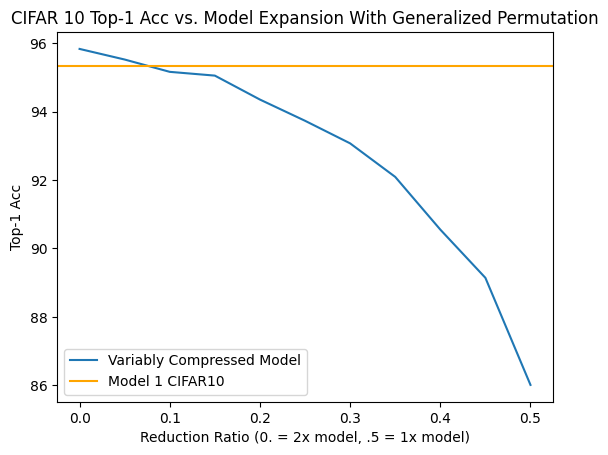

In [30]:
plt.plot(stepz, accs, label='Variably Compressed Model')
plt.axhline(95.34, color='orange', label='Model 1 CIFAR10')
plt.title('CIFAR 10 Top-1 Acc vs. Model Expansion With Generalized Permutation')
plt.xlabel('Reduction Ratio (0. = 2x model, .5 = 1x model)')
plt.ylabel('Top-1 Acc')
plt.legend()
plt.show()

In [29]:
new_transforms.keys()

dict_keys(['conv1', 'block1.0', 'block1.1', 'block1.2', 'block2.0', 'block2', 'block2.1', 'block2.2', 'block3.0', 'block3', 'block3.1', 'block3.2', 'linear'])

In [47]:
new_transforms['conv1'].next_input_align.sum(0).to(torch.int).bincount()

tensor([ 0, 25, 21, 14,  2,  1,  1], device='cuda:0')

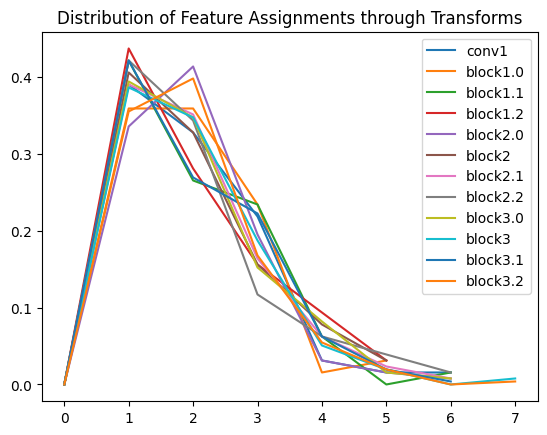

In [52]:
for key in new_transforms:
    try:
        freqs = new_transforms[key].next_input_align.sum(0).to(torch.int).bincount().to(torch.float).cpu().numpy()
        freqs /= freqs.sum()
        plt.plot(freqs, label=key)
    except:
        continue
plt.title('Distribution of Feature Assignments through Transforms')
plt.legend()
plt.show()

In [ ]:
step_size = .05
stepz = np.arange(0, .5 + step_size, step_size)
accs2 = []
for r in tqdm(stepz):
    set_r(r)
    set_match_fn(compress_tensors_exact_bipartite)

    match_tensors = match_wrapper(compress_tensors_exact_bipartite, interleave=False, random_perm=False)
    layer_transform = lambda : LayerTransform(normalize_tensors=True, tensor_merge_type='concat')
    old_state_dict = {}
    state_dict = {}
    old_transforms = defaultdict(lambda: layer_transform())
    new_transforms = defaultdict(lambda: layer_transform())
    modelc = resnet20(w=4, text_head=True).to(DEVICE)
    accuracies = []
    steps = []
    distances = []
    best_info = {'acc': 0., 'dist': np.inf}
    step = 1
    is_converged = False
    prev_distance = np.inf
    same_window = 5
    same_span = 0
    while not is_converged:
#     for step in range(10):
        old_transforms = new_transforms
        old_state_dict = deepcopy(state_dict)
        new_transforms = merge_resnet20(state_dict, modela, modelb, transforms=deepcopy(old_transforms))
        if step == 0:
            original_computation = deepcopy(new_transforms)

        transform2dist = find_transform_differences(old_transforms, new_transforms)
        avg_distance = np.mean(list(transform2dist.values()))

        if abs(avg_distance - prev_distance) <= 1e-5:
            same_span += 1
        else:
            same_span = 0
        if same_span >= same_window:
            is_converged = True

        prev_distance = avg_distance
    
        if is_converged:
            break
    model_comp = resnet20(w=4 * (1-r), num_classes=10).eval().to(DEVICE)
    model_comp.load_state_dict(state_dict)
    reset_bn_stats(model_comp, loader=train_aug_loader)
    acc = evaluate(model_comp) / 10000 * 100
    accs2.append(acc)
print(accs2)

In [57]:
step_size = .05
stepz = np.arange(0, .5 + step_size, step_size)
accs2 = []
for r in tqdm(stepz):
    set_r(r)
    set_match_fn(compress_tensors_exact_bipartite)

    match_tensors = match_wrapper(compress_tensors_exact_bipartite, interleave=False, random_perm=False)
    layer_transform = lambda : LayerTransform(normalize_tensors=True, tensor_merge_type='concat')
    old_state_dict = {}
    state_dict = {}
    old_transforms = defaultdict(lambda: layer_transform())
    new_transforms = defaultdict(lambda: layer_transform())
    modelc = resnet20(w=4, text_head=True).to(DEVICE)
    accuracies = []
    steps = []
    distances = []
    best_info = {'acc': 0., 'dist': np.inf}
    step = 1
    is_converged = False

    # while not is_converged:
    for step in range(10):
        old_transforms = new_transforms
        old_state_dict = deepcopy(state_dict)
        new_transforms = merge_resnet20(state_dict, modela, modelb, transforms=deepcopy(old_transforms))
        if step == 0:
            original_computation = deepcopy(new_transforms)

        is_converged, transform2dist = check_convergence(old_transforms, new_transforms)
        avg_distance = np.mean(list(transform2dist.values()))

        if is_converged:
            break

    model_comp = resnet20(w=4 * (1-r), num_classes=10).eval().to(DEVICE)
    model_comp.load_state_dict(state_dict)
    reset_bn_stats(model_comp, loader=train_aug_loader)
    acc = evaluate(model_comp) / 10000 * 100
    accs2.append(acc)
print(accs2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [01:22<00:00,  7.49s/it]

[95.34, 94.83, 94.44, 93.97, 92.78999999999999, 91.96, 90.82000000000001, 88.97, 86.21, 83.76, 79.73]


In [104]:
stepz

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ])

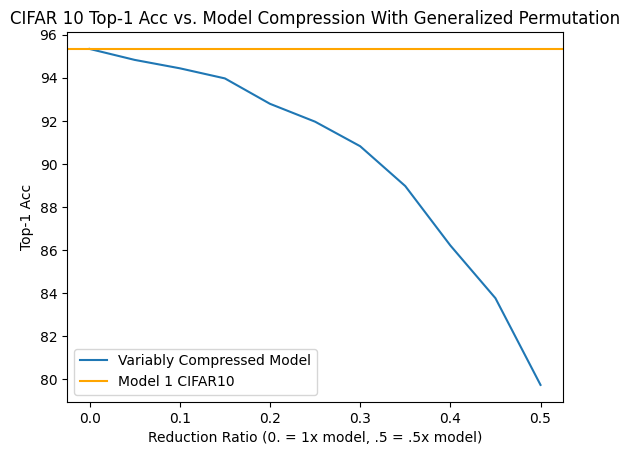

In [58]:
plt.plot(stepz, accs2, label='Variably Compressed Model')
plt.axhline(95.34, color='orange', label='Model 1 CIFAR10')
plt.title('CIFAR 10 Top-1 Acc vs. Model Compression With Generalized Permutation')
plt.xlabel('Reduction Ratio (0. = 1x model, .5 = .5x model)')
plt.ylabel('Top-1 Acc')
plt.legend()
plt.show()

## CIFAR 50

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pdb
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

import torch
from torch import nn
from torch.cuda.amp import GradScaler, autocast
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam, lr_scheduler
import torchvision
import torchvision.transforms as T

from sys import platform

DEVICE = 'mps' if platform == 'darwin' else 'cuda'
if DEVICE == 'mps':
    DOWNLOAD_PATH = '/Users/georgestoica/Downloads' 
else:
    DOWNLOAD_PATH = '/srv/share/gstoica3/checkpoints/REPAIR/'
    
torch.autograd.set_grad_enabled(False)

/srv/share/gstoica3/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from resnets import resnet20
from matching_algs import *
from model_matchings import *
from utils import *

In [6]:
cifar100_info = {
    'dir': '/nethome/gstoica3/research/pytorch-cifar100/data/cifar-100-python',
    'classes1': np.arange(50),
    'classes2': np.arange(50, 100),
    'num_classes': 100,
    'split_classes': 50
}

cifar10_info = {
    'dir': '/tmp',
    'classes1': np.array([3, 2, 0, 6, 4]),
    'classes2': np.array([5, 7, 9, 8, 1]),
    'num_classes': 10,
    'split_classes': 5
}


In [7]:
ds_info = cifar100_info

In [8]:
def save_model(model, i):
    sd = model.state_dict()
    path = os.path.join(
        # '/Users/georgestoica/Downloads',
        DOWNLOAD_PATH,
        '%s.pth.tar' % i
    )
    torch.save(model.state_dict(), path)

def load_model(model, i):
    path = os.path.join(
        # '/Users/georgestoica/Downloads',
        DOWNLOAD_PATH,
        '%s.pth.tar' % i
    )
    sd = torch.load(path, map_location=torch.device(DEVICE))
    model.load_state_dict(sd)
    return model


In [9]:
CIFAR_MEAN = [125.307, 122.961, 113.8575]
CIFAR_STD = [51.5865, 50.847, 51.255]
normalize = T.Normalize(np.array(CIFAR_MEAN)/255, np.array(CIFAR_STD)/255)
denormalize = T.Normalize(-np.array(CIFAR_MEAN)/np.array(CIFAR_STD), 255/np.array(CIFAR_STD))

train_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomCrop(32, padding=4),
    T.ToTensor(),
    normalize,
])
test_transform = T.Compose([
    T.ToTensor(),
    normalize,
])
train_dset = torchvision.datasets.CIFAR100(root=cifar10_info['dir'], train=True,
                                        download=True, transform=train_transform)
test_dset = torchvision.datasets.CIFAR100(root=cifar10_info['dir'], train=False,
                                        download=True, transform=test_transform)

train_aug_loader = torch.utils.data.DataLoader(train_dset, batch_size=500, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=500, shuffle=False, num_workers=8)

model1_classes= np.arange(50) # np.array([3, 2, 0, 6, 4])
model2_classes = np.arange(50, 100) # np.array([5, 7, 9, 8, 1])

valid_examples1 = [i for i, (_, label) in tqdm(enumerate(train_dset)) if label in model1_classes]
valid_examples2 = [i for i, (_, label) in tqdm(enumerate(train_dset)) if label in model2_classes]

assert len(set(valid_examples1).intersection(set(valid_examples2))) == 0, 'sets should be disjoint'

train_aug_loader1 = torch.utils.data.DataLoader(
    torch.utils.data.Subset(train_dset, valid_examples1), batch_size=500, shuffle=True, num_workers=8
)
train_aug_loader2 = torch.utils.data.DataLoader(
    torch.utils.data.Subset(train_dset, valid_examples2), batch_size=500, shuffle=True, num_workers=8
)

test_valid_examples1 = [i for i, (_, label) in tqdm(enumerate(test_dset)) if label in model1_classes]
test_valid_examples2 = [i for i, (_, label) in tqdm(enumerate(test_dset)) if label in model2_classes]

test_loader1 = torch.utils.data.DataLoader(
    torch.utils.data.Subset(test_dset, test_valid_examples1), batch_size=500, shuffle=False, num_workers=8
)
test_loader2 = torch.utils.data.DataLoader(
    torch.utils.data.Subset(test_dset, test_valid_examples2), batch_size=500, shuffle=False, num_workers=8
)

class_idxs = np.zeros(100, dtype=int)
class_idxs[model1_classes] = np.arange(50)
class_idxs[model2_classes] = np.arange(50)
class_idxs = torch.from_numpy(class_idxs)
class_idxs

Files already downloaded and verified
Files already downloaded and verified


50000it [00:13, 3582.04it/s]
50000it [00:14, 3503.28it/s]
10000it [00:01, 5223.63it/s]
10000it [00:01, 5332.03it/s]


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  0,  1,  2,  3,
         4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
        40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [10]:
DEVICE = 'cuda:0'
# evaluates accuracy
def evaluate(model, loader=test_loader, return_confusion=False):
    model.eval()
    correct = 0
    confusion_matrix = np.zeros((10, 10))
    with torch.no_grad(), autocast():
        for inputs, labels in loader:
            outputs = model(inputs.to(DEVICE))
            pred = outputs.argmax(dim=1)
            correct += (labels.to(DEVICE) == pred).sum().item()
            confusion_matrix[labels.cpu().numpy(), pred.cpu().numpy()] += 1
    confusion_matrix /= confusion_matrix.sum(-1, keepdims=True)
    if return_confusion:
        return correct, confusion_matrix
    else:
        return correct

In [11]:
import clip

text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in test_dset.classes]).to(DEVICE)
model, preprocess = clip.load('ViT-B/32', DEVICE)
with torch.no_grad():
    text_features = model.encode_text(text_inputs)

text_features /= text_features.norm(dim=-1, keepdim=True)
class_vecs1 = text_features[model1_classes]
class_vecs2 = text_features[model2_classes]

In [12]:
# evaluates accuracy
def evaluate_texthead(model, loader, class_vectors, remap_class_idxs=None, return_confusion=False):
    model.eval()
    correct = 0
    total = 0
    confusion = np.zeros((100, 100))
    
    totals = [0] * class_vectors.shape[0]
    corrects = [0] * class_vectors.shape[0]
    
    with torch.no_grad(), autocast():
        for inputs, labels in loader:
            encodings = model(inputs.to(DEVICE))
            normed_encodings = encodings / encodings.norm(dim=-1, keepdim=True)
            outputs = normed_encodings @ class_vectors.T
            pred = outputs.argmax(dim=1)
            if remap_class_idxs is not None:
                correct += (remap_class_idxs[labels].to(DEVICE) == pred).sum().item()
            else:
                for gt, p in zip(labels, pred):
                    totals[gt] += 1
                    
                    if gt == p:
                        correct += 1
                        corrects[gt] += 1
                
#                 correct += (labels.to(DEVICE) == pred).sum().item()
                
            confusion[labels.cpu().numpy(), pred.cpu().numpy()] += 1
            total += inputs.shape[0]
    if return_confusion:
        return correct / sum(totals), list(map(lambda a: a[0] / a[1], zip(corrects, totals)))
    else:
        return correct / total

In [13]:
model1 = resnet20(w=4, text_head=True, num_classes=ds_info['split_classes']).to(DEVICE)
model2 = resnet20(w=4, text_head=True, num_classes=ds_info['split_classes']).to(DEVICE)
load_model(model1, f'resnet20x4_CIFAR50_clses{model1_classes.tolist()}')
load_model(model2, f'resnet20x4_CIFAR50_clses{model2_classes.tolist()}')

print(evaluate_texthead(model1, test_loader1, class_vecs1, remap_class_idxs=class_idxs))
print(evaluate_texthead(model2, test_loader2, class_vecs2, remap_class_idxs=class_idxs))

0.778
0.7758


In [18]:
from collections import defaultdict
from copy import deepcopy

In [26]:
r = 0.05
set_r(r)
print(r)
set_match_fn(match_tensors_exact_bipartite)

match_tensors = match_wrapper(match_tensors_exact_bipartite, interleave=False, random_perm=False)
layer_transform = lambda : LayerTransform(normalize_tensors=False, tensor_merge_type='concat')
old_state_dict = {}
state_dict = {}
old_transforms = defaultdict(lambda: layer_transform())
new_transforms = defaultdict(lambda: layer_transform())
modelc = resnet20(w=4, text_head=True).to(DEVICE)
accuracies = []
steps = []
distances = []
best_info = {'acc': 0., 'dist': np.inf}
step = 1
is_converged = False

# while not is_converged:
for step in tqdm(range(100)):
    old_transforms = new_transforms
    old_state_dict = deepcopy(state_dict)
    copy_transform = deepcopy(old_transforms)
    new_transforms = merge_resnet20(state_dict, model1, model2, transforms=copy_transform)
    if step == 0:
        original_computation = deepcopy(new_transforms)

    is_converged, transform2dist = check_convergence(old_transforms, new_transforms)
    avg_distance = np.mean(list(transform2dist.values()))

    if is_converged:
        break
model_comp = resnet20(w=8 * (1-r), num_classes=ds_info['num_classes'], text_head=True).eval().to(DEVICE)
model_comp.load_state_dict(state_dict)
reset_bn_stats(model_comp, loader=train_aug_loader)
acc = evaluate_texthead(model_comp, test_loader, class_vectors=text_features) * 100
print(acc)

0.05


 11%|█████▎                                          | 11/100 [00:01<00:14,  6.22it/s]


67.52


In [18]:
def kmeans_wrapper(interleave=False, random_perm=False, r=.5, seed=0):
    return lambda x: kmeans_matching(x, interleave=interleave, random_perm=random_perm, r=r, seed=seed)

In [27]:
step_size = .05
stepz = np.arange(0, .5 + step_size, step_size)
cifar50_accs = []
for r in tqdm(stepz):
    set_r(r)
#     set_match_fn(kmeans_wrapper(r=r))
    set_match_fn(match_tensors_exact_bipartite)

    # match_tensors = match_wrapper(kmeans_matching, interleave=False, random_perm=False)
#     match_tensors = 
    layer_transform = lambda : LayerTransform(normalize_tensors=False, tensor_merge_type='concat')
    old_state_dict = {}
    state_dict = {}
    old_transforms = defaultdict(lambda: layer_transform())
    new_transforms = defaultdict(lambda: layer_transform())
    modelc = resnet20(w=4, text_head=True).to(DEVICE)
    accuracies = []
    steps = []
    distances = []
    best_info = {'acc': 0., 'dist': np.inf}
    step = 1
    is_converged = False

    # while not is_converged:
    for step in range(100):
        old_transforms = new_transforms
        old_state_dict = deepcopy(state_dict)
        new_transforms = merge_resnet20(state_dict, model1, model2, transforms=deepcopy(old_transforms))
        if step == 0:
            original_computation = deepcopy(new_transforms)

        is_converged, transform2dist = check_convergence(old_transforms, new_transforms)
        avg_distance = np.mean(list(transform2dist.values()))

        if is_converged:
            break
    
    model_comp = resnet20(w=8 * (1-r), num_classes=ds_info['num_classes'], text_head=True).eval().to(DEVICE)
    model_comp.load_state_dict(state_dict)
    reset_bn_stats(model_comp, loader=train_aug_loader)
    acc = evaluate_texthead(model_comp, test_loader, class_vectors=text_features) * 100
    cifar50_accs.append(acc)

100%|█████████████████████████████████████████████████| 11/11 [05:26<00:00, 29.67s/it]


In [28]:
print(cifar50_accs)

[68.82000000000001, 67.53, 65.25999999999999, 63.029999999999994, 60.89, 58.36, 55.43, 52.55, 47.949999999999996, 44.26, 38.54]


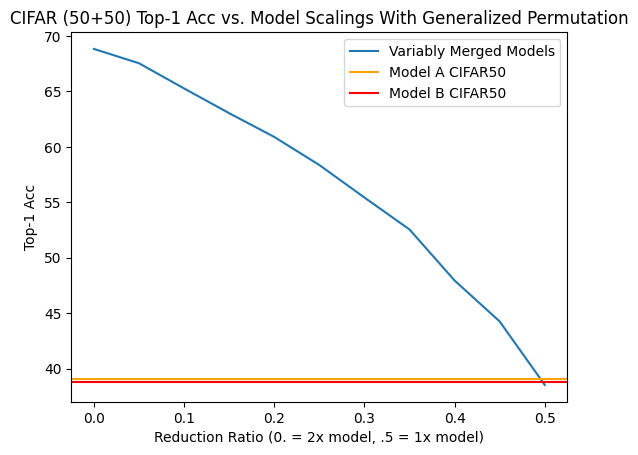

In [30]:
plt.plot(stepz, cifar50_accs, label='Variably Merged Models')
plt.axhline(39.04, color='orange', label='Model A CIFAR50')
plt.axhline(38.84, color='red', label='Model B CIFAR50')
plt.title('CIFAR (50+50) Top-1 Acc vs. Model Scalings With Generalized Permutation')
plt.xlabel('Reduction Ratio (0. = 2x model, .5 = 1x model)')
plt.ylabel('Top-1 Acc')
plt.legend()
plt.show()

In [41]:
step_size = .05
stepz = np.arange(0, .5 + step_size, step_size)
accs2 = []
for r in tqdm(stepz):
    set_r(r)
    set_match_fn(compress_tensors_exact_bipartite)

    match_tensors = match_wrapper(compress_tensors_exact_bipartite, interleave=False, random_perm=False)
    layer_transform = lambda : LayerTransform(normalize_tensors=True, tensor_merge_type='concat')
    old_state_dict = {}
    state_dict = {}
    old_transforms = defaultdict(lambda: layer_transform())
    new_transforms = defaultdict(lambda: layer_transform())
    modelc = resnet20(w=4, text_head=True).to(DEVICE)
    accuracies = []
    steps = []
    distances = []
    best_info = {'acc': 0., 'dist': np.inf}
    step = 1
    is_converged = False

    # while not is_converged:
    for step in range(10):
        old_transforms = new_transforms
        old_state_dict = deepcopy(state_dict)
        new_transforms = merge_resnet20(state_dict, model1, model1, transforms=deepcopy(old_transforms))
        if step == 0:
            original_computation = deepcopy(new_transforms)

        is_converged, transform2dist = check_convergence(old_transforms, new_transforms)
        avg_distance = np.mean(list(transform2dist.values()))

        if is_converged:
            break

    model_comp = resnet20(w=4 * (1-r), text_head=True).eval().to(DEVICE)
    model_comp.load_state_dict(state_dict)
    reset_bn_stats(model_comp, loader=train_aug_loader)
    acc = evaluate_texthead(model_comp, test_loader1, class_vecs1, remap_class_idxs=class_idxs) * 100
    accs2.append(acc)
print(accs2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [01:18<00:00,  7.14s/it]

[80.0, 78.7, 77.84, 76.08, 74.26, 71.84, 68.72, 64.96, 61.53999999999999, 53.559999999999995, 49.08]


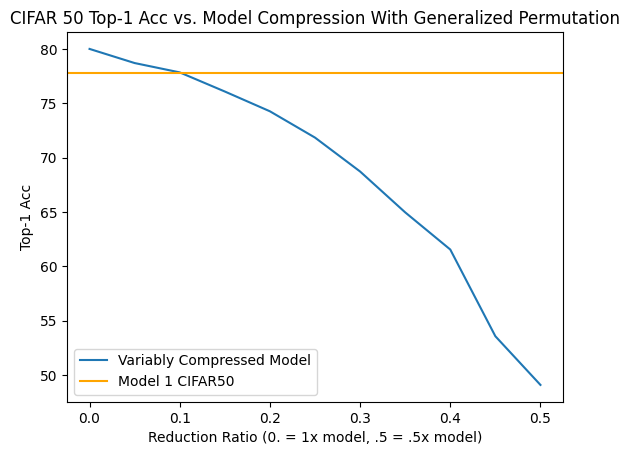

In [46]:
plt.plot(stepz, accs2, label='Variably Compressed Model')
plt.axhline(77.8, color='orange', label='Model 1 CIFAR50')
plt.title('CIFAR 50 Top-1 Acc vs. Model Compression With Generalized Permutation')
plt.xlabel('Reduction Ratio (0. = 1x model, .5 = .5x model)')
plt.ylabel('Top-1 Acc')
plt.legend()
plt.show()